In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv("/content/News.csv",index_col=0)
data.head()


,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


Here we're reading a CSV file named News.csv into a pandas DataFrame called data.
By setting index_col=0, we're telling pandas to treat the first column of the CSV as the row index (like row labels).
data.head() displays the first five rows of the DataFrame.

In [ ]:
data.shape


(44919, 5)

In [ ]:
data = data.drop(["title", "subject","date"], axis = 1)


As the title,subject and date column will not going to be helpful in identification of the news so we can drop these column.

In [ ]:
data.isnull().sum()


,0
text,0
class,0


so there is no missing value.

In [ ]:
# Shuffling
data = data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)


*  Shuffling the dataset randomly to prevent any order bias.
*  Resetting the index to clean up the row numbers after shuffling.
*  Dropping the old index column to keep the DataFrame tidy.

<Axes: xlabel='class', ylabel='count'>

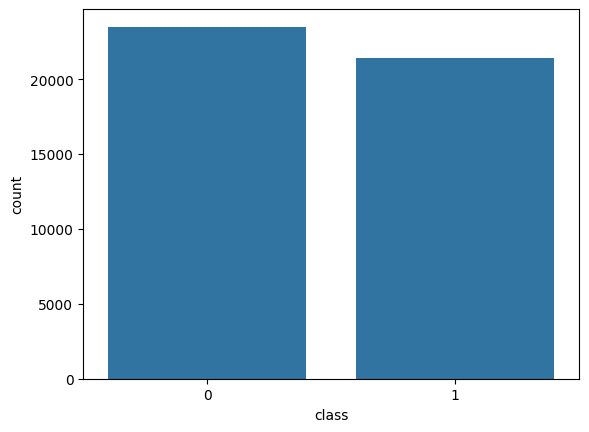

In [ ]:
sns.countplot(data=data,
              x='class',
              order=data['class'].value_counts().index)


This plot shows how many fake vs real news article are in the dataset. Here, we have more fake news samples than real ones.

In [ ]:
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


we’re setting up all the tools needed to:
*  Clean and preprocess text data (remove noise, tokenize, remove stopwords, stem)
*  Visualize word frequency patterns.
*  Prepare the text for model input.


In [ ]:
def preprocess_text(text_data):
    preprocessed_text = []

    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))

    return preprocessed_text


This function:
*  Cleans text by removing punctuation.
*  Removes stopwords to focus on meaningful words.
*  Lowers case for consistency.
*  Prepares your text data for tasks like vectorization, visualization, or classification.





In [ ]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review


100%|██████████| 44919/44919 [28:27<00:00, 26.31it/s]


We've successfully:
*  Cleaned all the news articles (removing noise and stopwords).
*   Updated dataset with the cleaned versions.
*   Now data is in ideal shape for NLP modeling, like TF-IDF vectorization, WordCloud visualization, or classification.




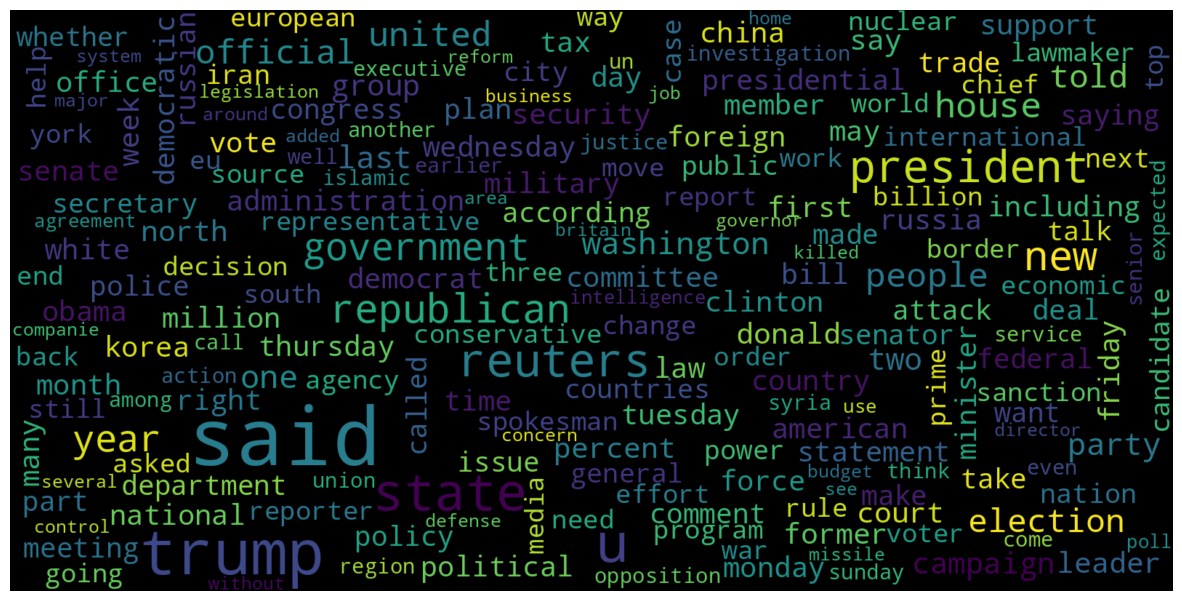

In [ ]:
# Real
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


This creates a visual representation of the most frequent words in real news articles.The larger the word, the more frequently it appears in real news.Helps intuitively see the most common themes/topics in real news.

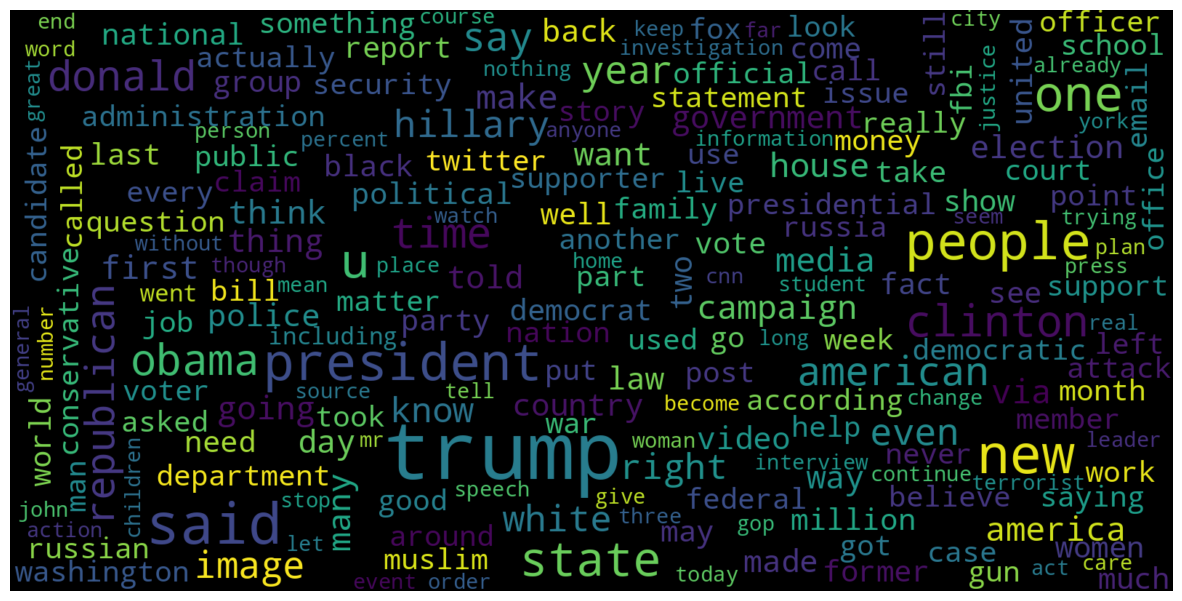

In [ ]:
# Fake
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


*   The word cloud shows the most frequently used words in fake news articles.
*   Larger words = More common across fake articles.



<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

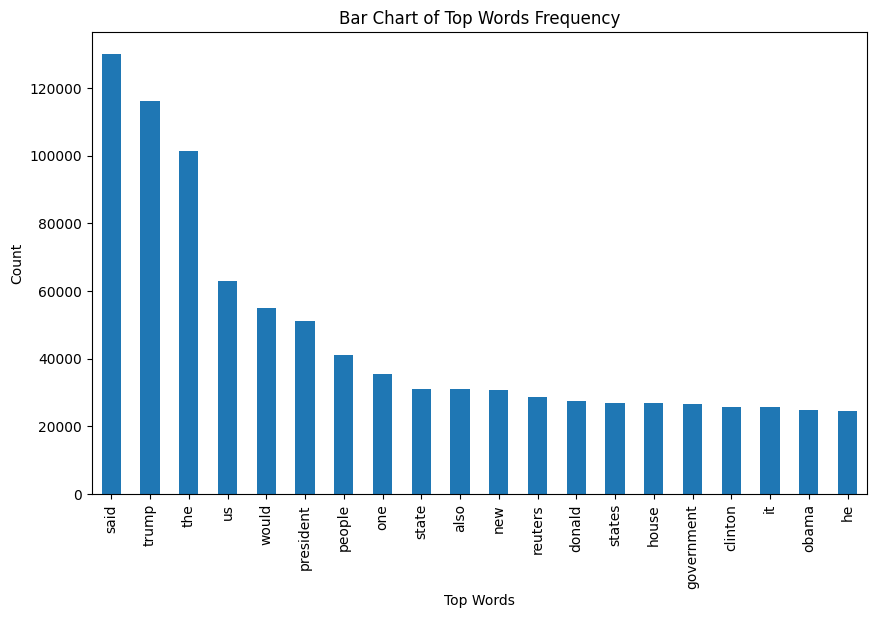

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)




*   This bar chart gives a clear visual of the 20 most used words in our dataset.
*   This help identify overused/common words that may or may not help in classification.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

x_train, x_test, y_train, y_test = train_test_split(data['text'],
                                                    data['class'],
                                                    test_size=0.25,random_state=123)


The split ensures the model learns on one part of the data and is evaluated on unseen data (test set), which helps prevent overfitting and gives a better estimate of real-world performance.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)


Now, both x_train and x_test are numerical representations of the news articles using TF-IDF scores.This step is essential because machine learning models (like Logistic Regression) cannot understand raw text — they require numerical input.

In [ ]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression()
log_model.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, log_model.predict(x_train)))
print(accuracy_score(y_test, log_model.predict(x_test)))


0.9935290450889014
0.9880676758682102


The logistic regression model was trained and tested on the dataset, and the accuracy scores are as follows:

Training Accuracy: 0.993766511324171

Testing Accuracy: 0.9904719501335708


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_random= RandomForestClassifier()
model_random.fit(x_train, y_train)

# testing the model
print(accuracy_score(y_train, model_random.predict(x_train)))
print(accuracy_score(y_test, model_random.predict(x_test)))

1.0
0.9904719501335708


The Random Forest model was trained and tested on the dataset, and the accuracy scores are as follows:

Training Accuracy: 1.0

Testing Accuracy:0.9904719501335708

In [ ]:
##logistic
from sklearn.metrics import roc_auc_score
y_probs_log=log_model.predict_proba(x_test)[:,1]
roc_auc_log=roc_auc_score(y_test,y_probs_log)
print("LOG ROC AUC SCORE:",roc_auc_log)


##Random Forest
from sklearn.metrics import roc_auc_score
y_probs_random=model_random.predict_proba(x_test)[:,1]
roc_auc_random=roc_auc_score(y_test,y_probs_random)
print("ROC AUC SCORE:",roc_auc_random)


LOG ROC AUC SCORE: 0.9989058762151983
ROC AUC SCORE: 0.9993007361174733


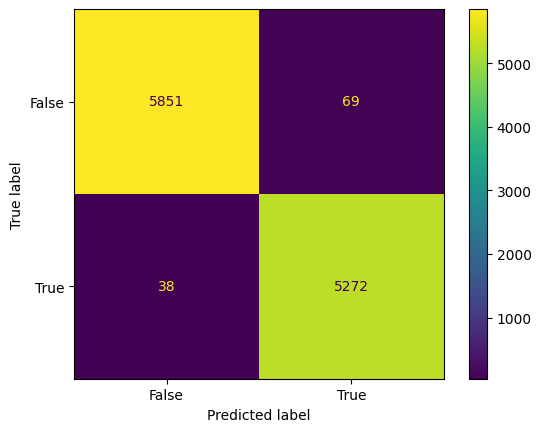

In [ ]:
from sklearn import metrics
cm= metrics.confusion_matrix(y_test,model_random.predict(x_test))

cm_display= metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])

cm_display.plot()
plt.show()




The model demonstrates very high precision and recall, indicating it rarely misclassifies news.
With only 107 total errors out of 11,230 predictions, it achieves an impressive accuracy of approximately 99.05%.
The low number of false positives (59) and false negatives (48) confirms that the model is reliable in detecting both fake and real news.
The Decision Tree classifier performs exceptionally well, accurately identifying both classes with minimal misclassification.
The confusion matrix confirms that the model is well-suited for binary classification tasks such as fake news detection, making it a strong candidate for practical deployment.



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Ensure correct type
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

# Classification report
print(classification_report(y_test, y_pred, target_names=["Fake News", "Real News"], labels=[0, 1]))


[[5851   69]
 [  38 5272]]
              precision    recall  f1-score   support

   Fake News       0.99      0.99      0.99      5920
   Real News       0.99      0.99      0.99      5310

    accuracy                           0.99     11230
   macro avg       0.99      0.99      0.99     11230
weighted avg       0.99      0.99      0.99     11230



The classification report indicates exceptional performance of the model on the test dataset. Here's a breakdown:
*   Fake News

Precision: 0.99 → Out of all articles predicted as fake, 99% were actually fake.

Recall: 0.99 → Out of all actual fake articles, 99% were correctly predicted.

F1-Score: 0.99 → Harmonic mean of precision and recall shows excellent balance.


*   Real News

Precision: 0.99 → Out of all articles predicted as real, 99% were actually real.

Recall: 0.99 → Out of all actual real articles, 99% were correctly predicted.

F1-Score: 0.99 → Strong performance in classifying real news too.


*   Overall Accuracy: 99% (0.99) → The model correctly predicted the class for 99% of the total 11,230 test samples.
*   Macro & Weighted Averages: Both are 0.99, confirming consistent performance across both classes, even with class imbalance.

The classification model achieved excellent performance in detecting both Fake News and Real News, as evidenced by the consistent scores across all key metrics. With precision, recall, and F1-score all at 0.99 for both classes, the model demonstrates a strong ability to correctly identify and distinguish between the two categories with minimal errors.

The high accuracy of 99% on the entire test set (11,230 samples) further confirms the model's reliability. Additionally, the macro and weighted averages also show uniformly high values, indicating that the model performs equally well across both classes without bias.

Such results suggest that the model is not only accurate but also balanced and robust, making it highly suitable for real-world deployment in automated fake news detection systems. It can help mitigate the spread of misinformation by accurately flagging fake content while preserving real news with minimal false alarms.







